In [1]:
import gymnasium as gym
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter, CryoWorldModel, generate_sweep
%config InlineBackend.figure_formats = ['png']

In [2]:
torch.cuda.is_available()

False

In [3]:
warnings.simplefilter('ignore')
gym.logger.set_level(40)

In [4]:
buffer_size = 1200

env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=0.01,
                   sample_pars=False,
                   log_reward=False,
                   rand_start=True,
                   relax_time=45,
                   tpa_in_state=False,
                   pars={'store_raw': False,
                         'max_buffer_len': buffer_size,
                         'tpa_queue': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'pileup_prob': 0.,
                         'xi': np.array([1e1]),
                         'tau': np.array([45]),  # 45
                         'tp_interval': 10,
                         'tes_fluct': np.array([2e-4]),
                         'emi': np.array([2e-10]),
                         'pulser_scale': np.array([1]),
                        },
               render_mode='human',
                   )

ADC range exceeded!


# manual control

In [5]:
env.detector.set_control(dac=np.array([-0.7]), Ib=np.array([-.8]), norm=True)

In [6]:
env.detector.wait(10)

ADC range exceeded!


In [7]:
env.detector.trigger(er=np.array([0., 0.]), tpa=np.array([10.]))

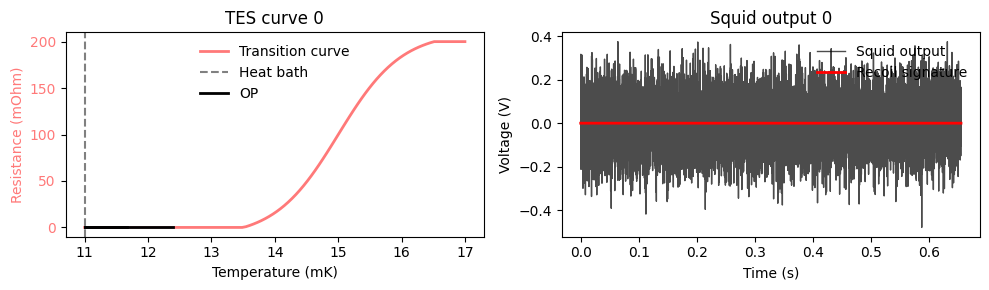

In [8]:
env.detector.plot_tes()

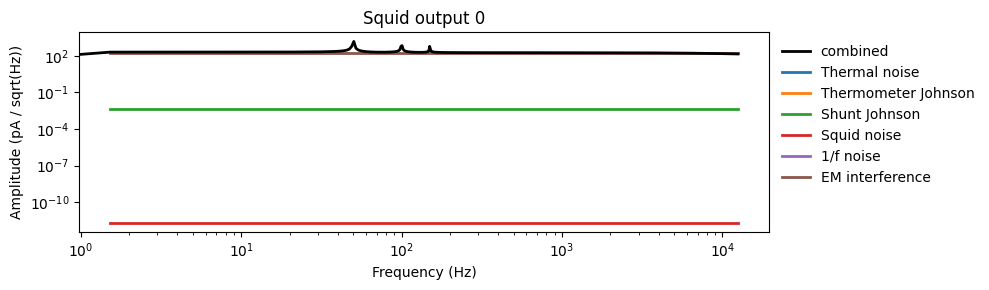

In [9]:
env.detector.plot_nps()

# training

In [6]:
obs, info = env.reset()

In [7]:
# world_model = CryoWorldModel()

In [8]:
# worked for bs = 8, grs = 5 after 16 60 step EPs, without sweep
# worked for bs = 16, grs = 20 after ~10 60 step EPs, without sweep
# higher noise, higher omega, already after 6 EPs

model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=3e-4, buffer_size=buffer_size, learning_starts=0,
                        batch_size=16, gamma=.99, gradient_steps=20, grad_clipping=.5, tau=0.005, # model_steps=15, # world_model=world_model,
                        device='cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [10]:
# force the sweep

ops = generate_sweep(12,10)

state = obs

for dac,ib in tqdm(ops):
    action = np.array([dac, ib])
    next_state, reward, terminated, truncated, info = model.env.step(action)
    model.buffer.store_transition(state, action, reward, next_state, terminated)
    state = next_state

  0%|          | 0/120 [00:00<?, ?it/s]

In [11]:
model.learn(episodes = 18, 
            episode_steps = 60, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

# buffer

In [12]:
# world_model.get_reward()

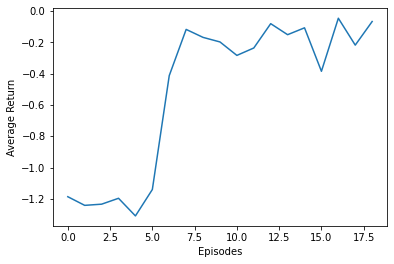

In [13]:
tracker.plot(smooth=1)

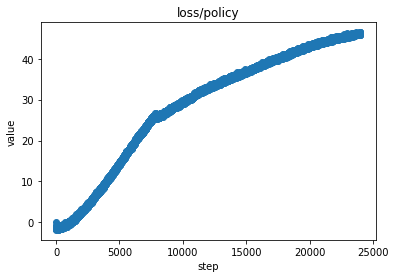

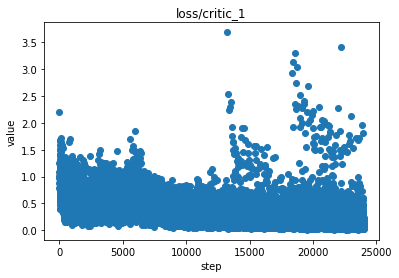

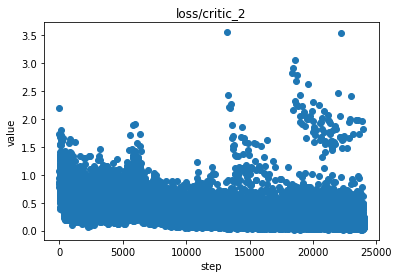

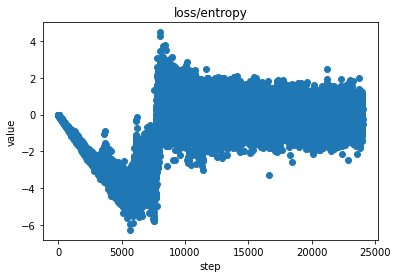

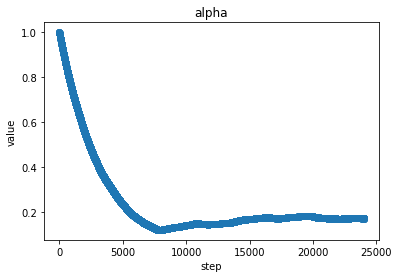

In [14]:
for key in writer.history.keys():
    writer.plot(key)

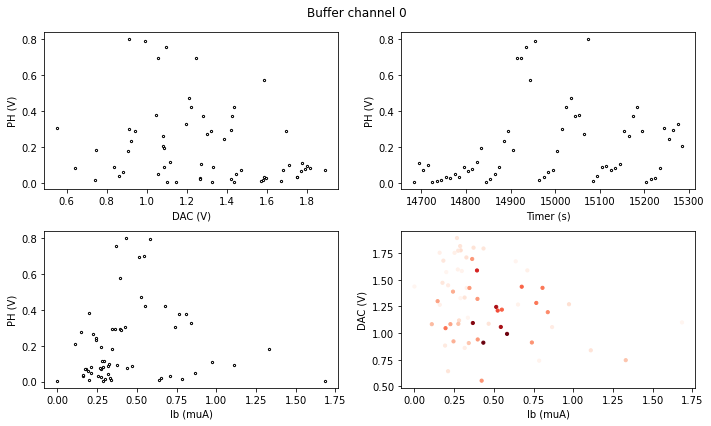

In [15]:
env.detector.plot_buffer()

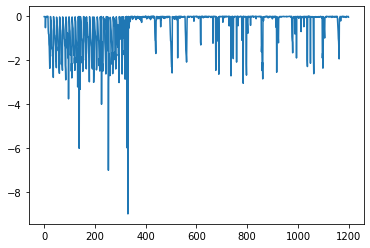

In [24]:
plt.plot(model.buffer.reward_memory[:1200])
# plt.ylim(-.01,0.001)

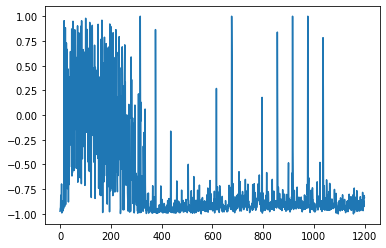

In [25]:
plt.plot(model.buffer.state_memory[:1200,2])

# inference

  0%|          | 0/10 [00:00<?, ?it/s]

[[-0.13995329 -0.07829281]]
[-0.99921863 -0.99978652 -0.07829273 -0.13995326] -2.7428206130670505


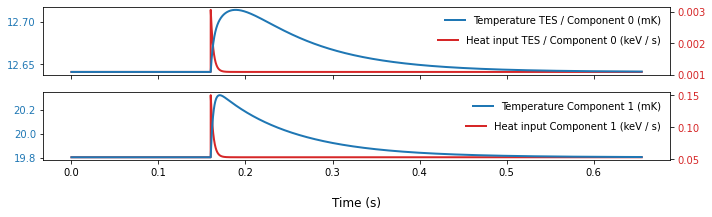

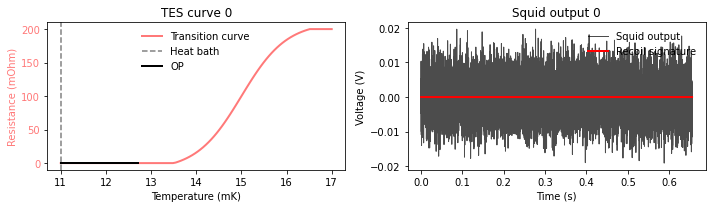

[[-0.5758827 -0.9023101]]
[-0.99914394 -0.99978642 -0.90231007 -0.57588267] -0.03363972672908922


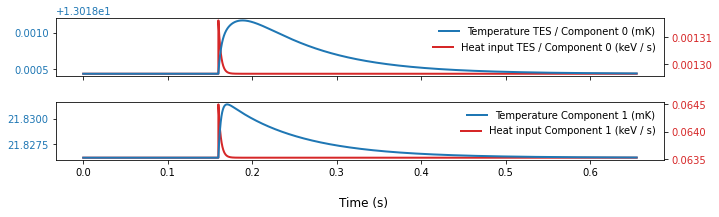

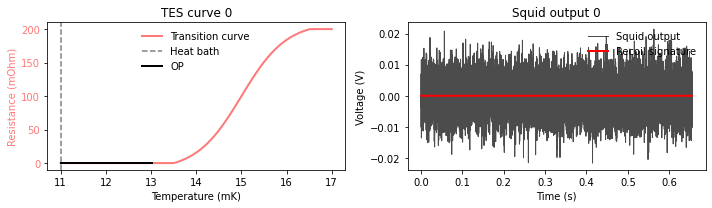

[[-0.53518367 -0.91844904]]
[-0.99911884 -0.9997907  -0.91844904 -0.53518367] -0.11878556571718113


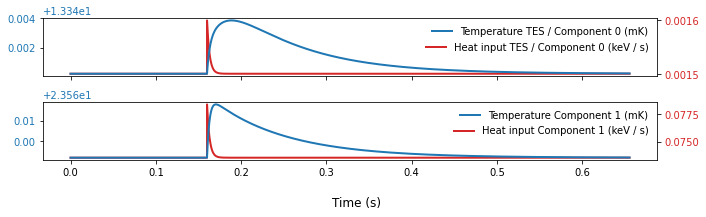

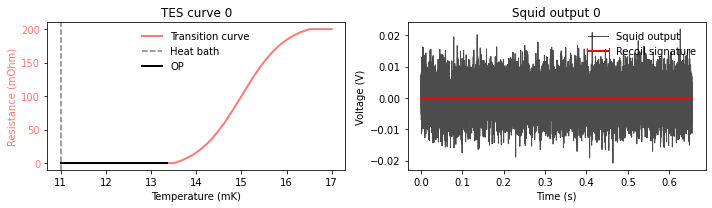

[[-0.56478775 -0.91784203]]
[-0.9873857  -0.99980139 -0.91784203 -0.56478775] -0.015753687727171485


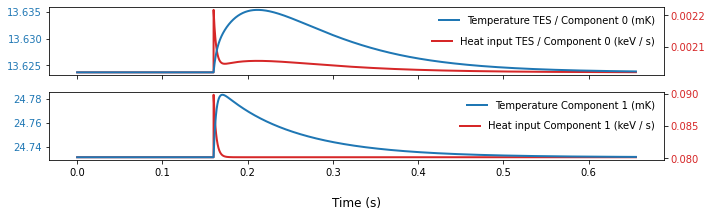

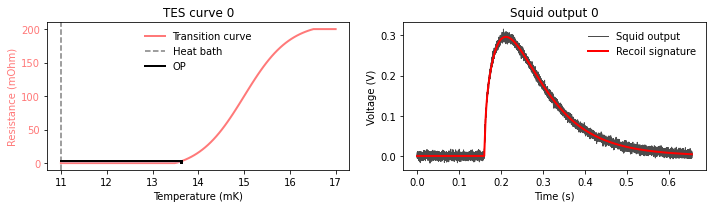

[[-0.5417881  -0.91761994]]
[-0.98114263 -0.99984823 -0.91761994 -0.5417881 ] -0.016101610819237444


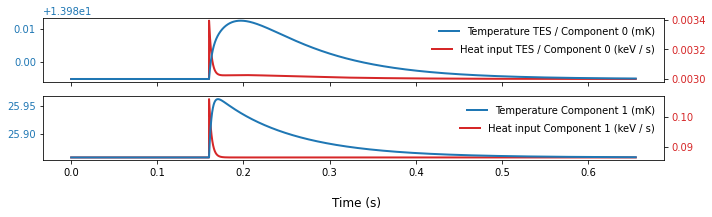

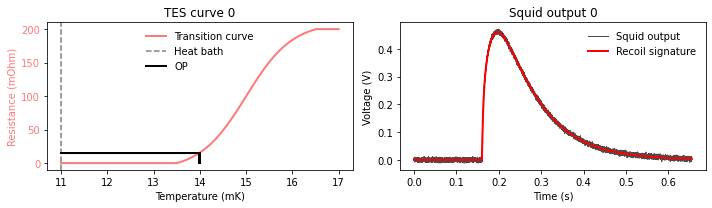

[[-0.5592728  -0.91699195]]
[-0.976432   -0.99987125 -0.91699195 -0.55927283] -0.01639125164529153


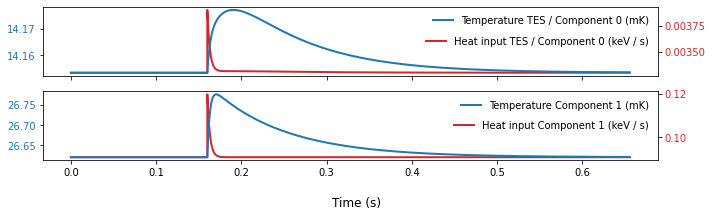

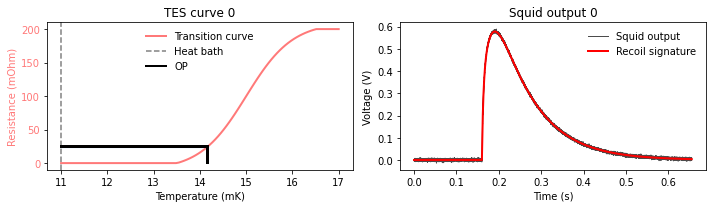

[[-0.54586405 -0.9169679 ]]
[-0.97360569 -0.99988873 -0.91696793 -0.54586405] -0.01686477770195328


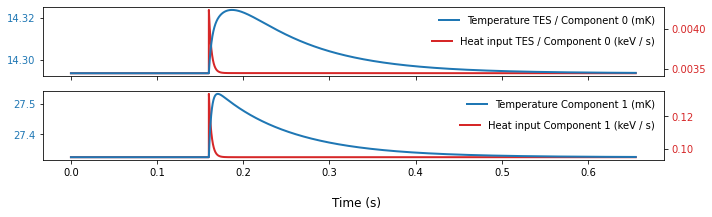

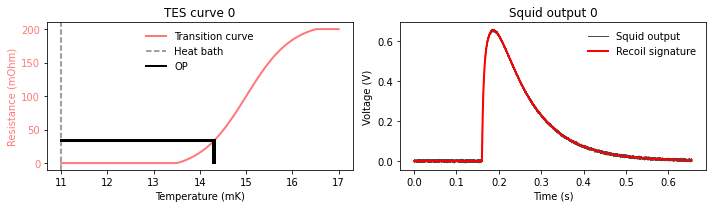

[[-0.5559354 -0.9166453]]
[-0.97048156 -0.99989792 -0.91664529 -0.55593538] -0.017291480938869862


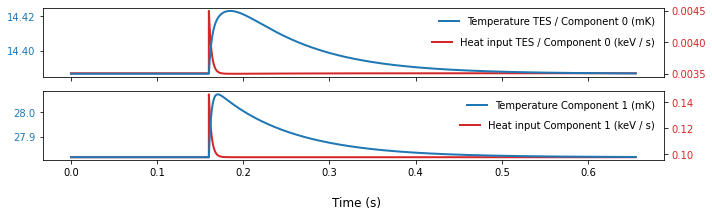

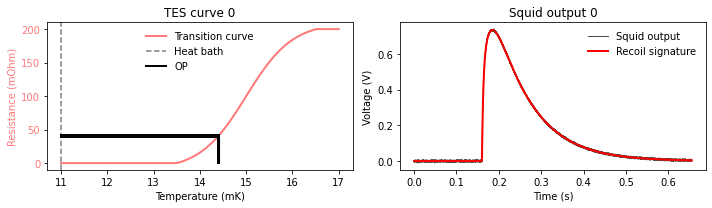

[[-0.5483218 -0.9166058]]
[-0.96797358 -0.99990722 -0.91660577 -0.54832178] -0.017382525524375334


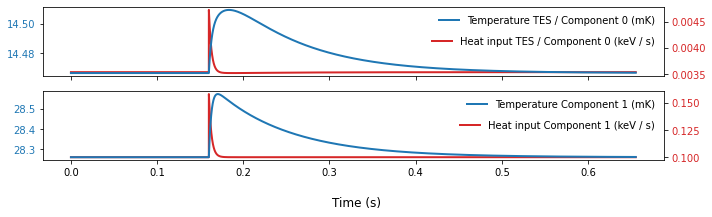

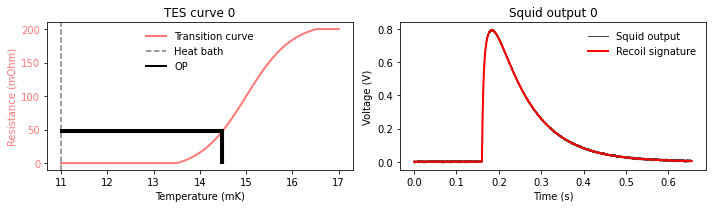

[[-0.5540431 -0.9163733]]
[-0.96522491 -0.99990843 -0.91637331 -0.55404311] -0.018433310048149992


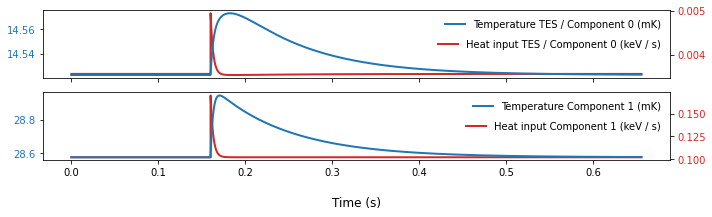

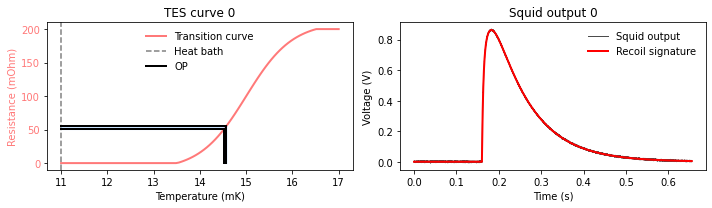

In [21]:
obs, _ = env.reset()
model.policy.eval()
returns = 0
for i in trange(10):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    print(action)
    print(obs, reward)
    returns += reward
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

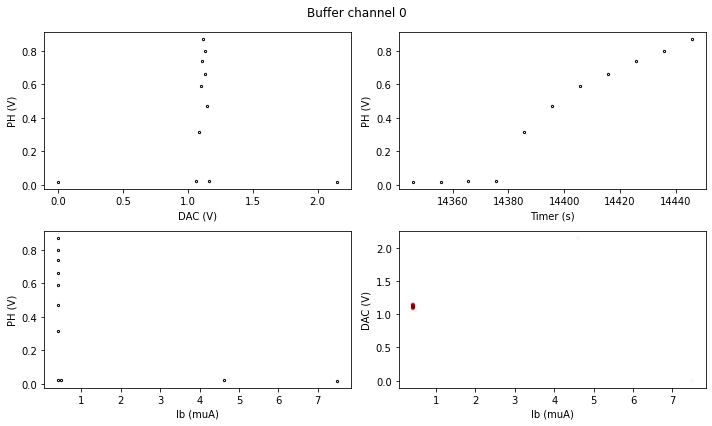

In [22]:
env.detector.plot_buffer()

In [23]:
# env.close()

# analyze policy

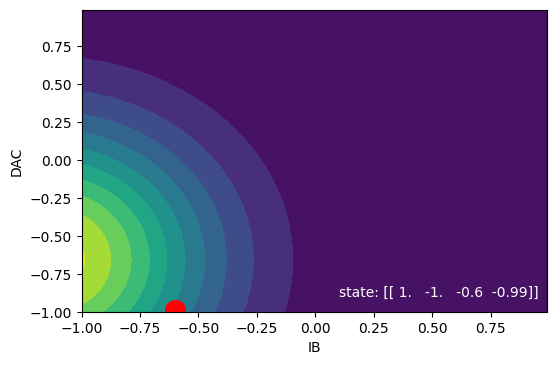

In [161]:
from scipy.stats import multivariate_normal

obs = torch.tensor([1, -1, -0.6, -.99]).reshape(1, -1)  # PH, RMS, IB, DAC

mu, log_std = model.policy(obs)
mu = mu.detach().numpy().flatten()
with torch.no_grad():
    log_std = log_std.numpy().flatten()

rv = multivariate_normal(mu, np.diag(np.exp(log_std)))

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))

fig2 = plt.figure(dpi=100)
ax2 = fig2.add_subplot(111)
ax2.contourf(y, x, rv.pdf(pos), levels=10)  # IB, DAC
plt.scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1))
plt.text(0.1, -0.9, 'state: {}'.format(obs.numpy()), color='white')
plt.ylabel('DAC')
plt.xlabel('IB')
plt.show()

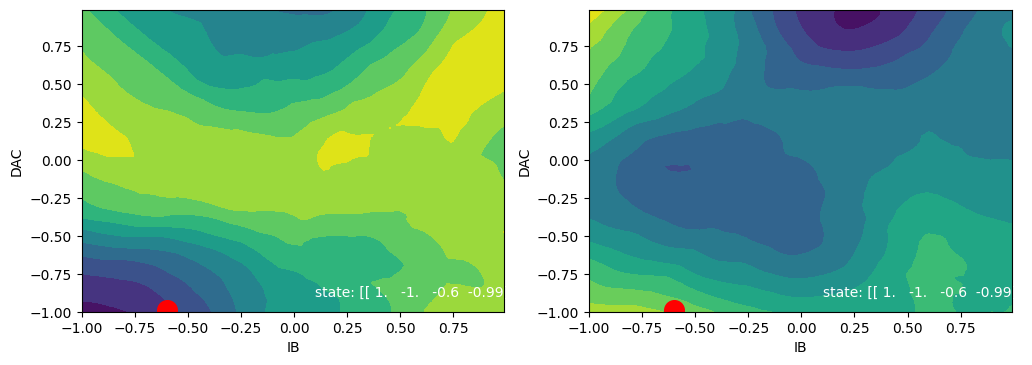

In [169]:
# obs = torch.tensor([1, -1, -0.6, .25]).reshape(1, -1)  # PH, RMS, IB, DAC
action = torch.tensor([[x_,y_] for x_,y_ in zip(x.flatten(), y.flatten())], dtype=torch.float32)

with torch.no_grad():
    val1, val2 = model.target_critic(torch.tile(obs, (40000,1)), action)

fig, ax = plt.subplots(1,2,dpi=100,figsize=(12,4))

ax[0].contourf(y, x, val1.reshape(200,200), levels=10)  # IB, DAC
ax[0].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1))
ax[0].text(0.1, -0.9, 'state: {}'.format(obs.numpy()), color='white')
ax[0].set_ylabel('DAC')
ax[0].set_xlabel('IB')

ax[1].contourf(y, x, val2.reshape(200,200), levels=10)  # IB, DAC
ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1))
ax[1].text(0.1, -0.9, 'state: {}'.format(obs.numpy()), color='white')
ax[1].set_ylabel('DAC')
ax[1].set_xlabel('IB')

plt.show()